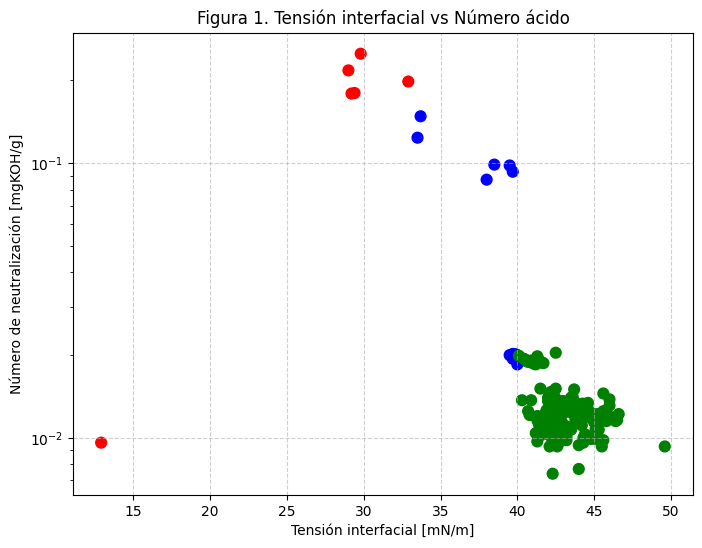

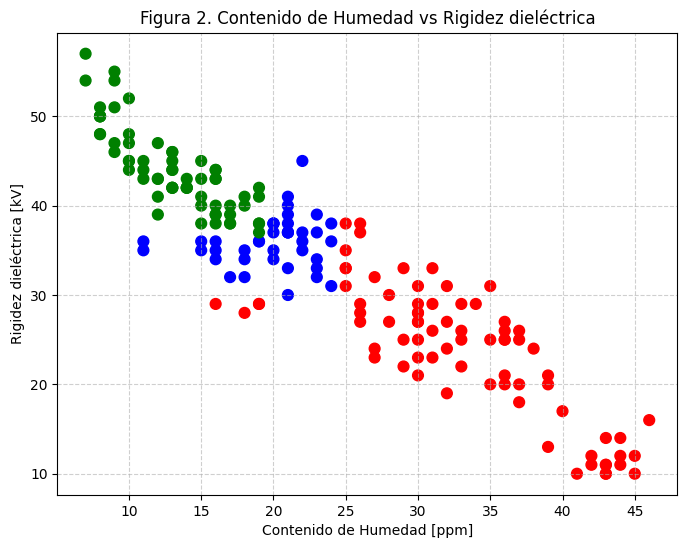

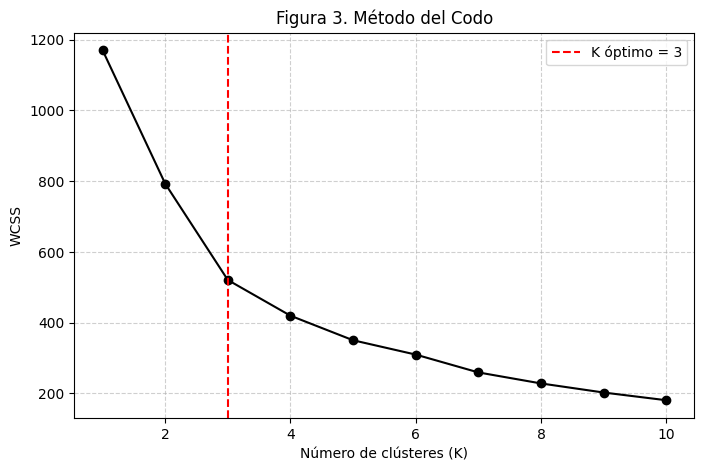


Silhouette Score (K=3): 0.380


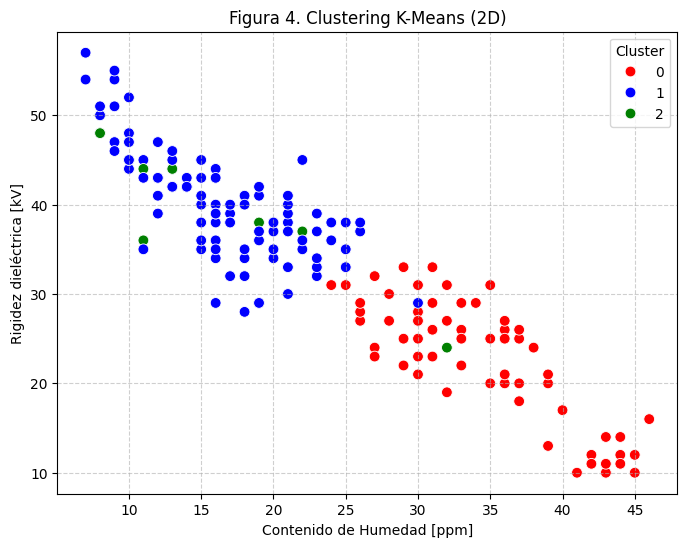

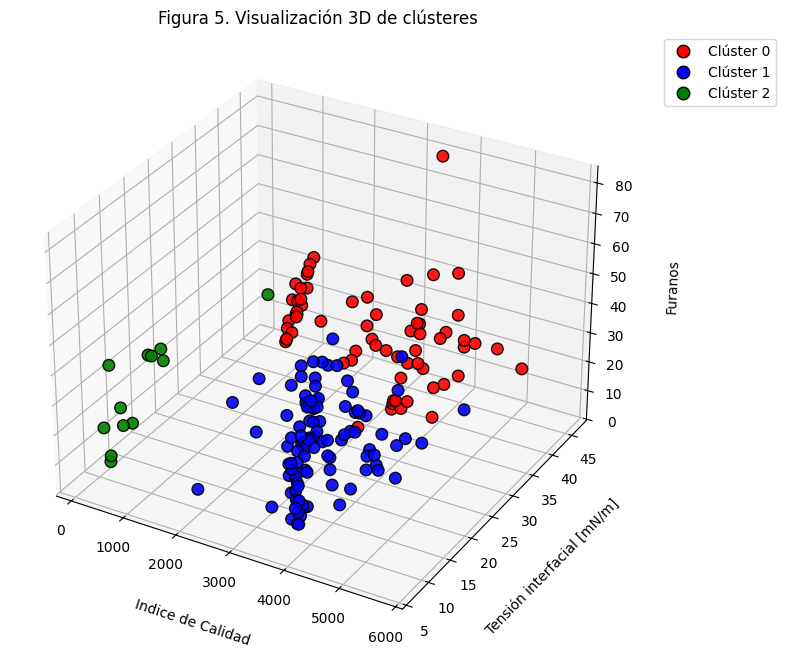


Promedio de R por clúster:
 Cluster
0    0.042720
1    0.022437
2   -0.453719
Name: R, dtype: float64


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [01:16:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


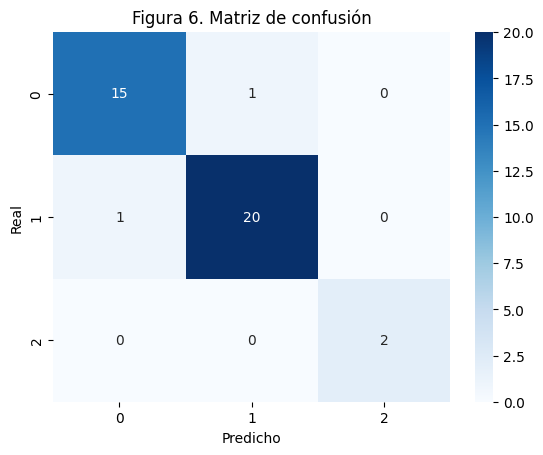

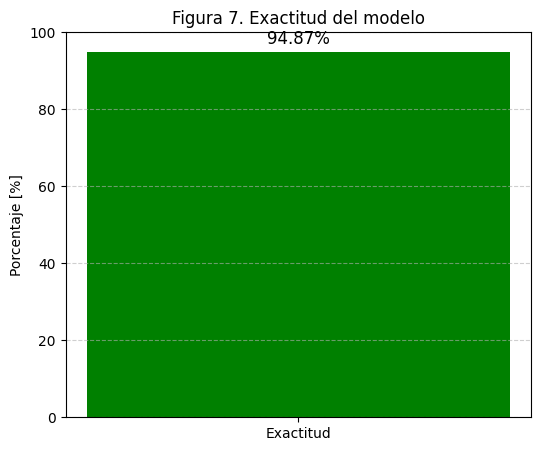

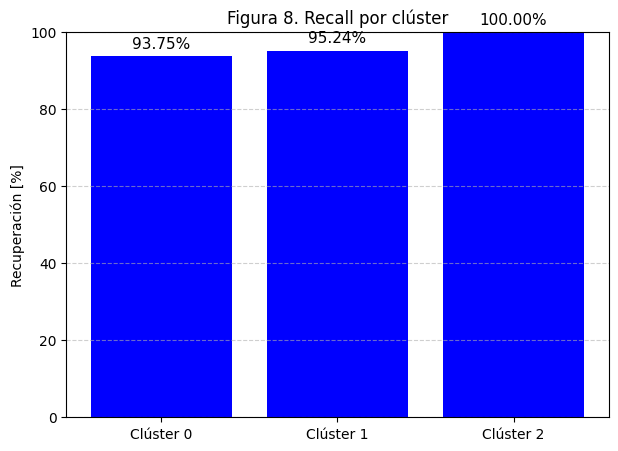


Tabla I – Parámetros estadísticos por clúster
         Tensión interfacial  Número ácido  Rigidez dieléctrica   \
Cluster                                                            
0                      42.32          0.01                 22.61   
1                      43.58          0.01                 40.18   
2                      32.18          0.14                 40.25   

         Contenido de Humedad  Furanos  Indice de Calidad     R  Nº Transf.  
Cluster                                                                      
0                       34.45    33.15            3201.61  0.04          66  
1                       16.40    23.65            3663.83  0.02         117  
2                       15.58    23.67             353.61 -0.45          12  

Tabla II – Métricas de rendimiento
              precision    recall  f1-score    support
0              0.937500  0.937500  0.937500  16.000000
1              0.952381  0.952381  0.952381  21.000000
2              1.0000

In [ ]:
# ============================================
# Proyecto: Diagnóstico de Transformadores con IA
# Autor: Juan David Garcia Correa and Armando Jaime Ustariz Farfan
# Descripción: Pipeline híbrido K-Means + XGBoost
#              para clasificación automática de condición
# ============================================

# ==== 1. Librerías ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report, accuracy_score, recall_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# ==== 2. Cargar y preparar datos ====
df = pd.read_csv("DATA_frame.csv", sep=";", encoding="utf-8")
df = df.drop(columns="Unnamed: 23", errors="ignore")
df = df.replace(",", ".", regex=True)
df = df.apply(pd.to_numeric, errors="coerce")

# Selección de variables relevantes
variables = [
    "Tensión interfacial",
    "Número ácido",
    "Rigidez dieléctrica ",
    "Contenido de Humedad",
    "Furanos",
    "Indice de Calidad"
]
df = df[variables]

# Imputación y normalización
imputer = SimpleImputer(strategy="mean")
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_imputed)

# =======================================================
# Figura 1 – Tensión interfacial vs Número ácido
# =======================================================
def clasificar_estado_f1(ti, nn):
    if ti > 40 and nn < 0.1:
        return "green"
    elif 35 <= ti <= 40 or 0.1 <= nn <= 0.15:
        return "blue"
    else:
        return "red"

colores_f1 = [clasificar_estado_f1(ti, nn) for ti, nn in zip(df["Tensión interfacial"], df["Número ácido"])]

plt.figure(figsize=(8, 6))
plt.scatter(df["Tensión interfacial"], df["Número ácido"], c=colores_f1, marker="o", s=60)
plt.xlabel("Tensión interfacial [mN/m]")
plt.ylabel("Número de neutralización [mgKOH/g]")
plt.yscale("log")
plt.title("Figura 1. Tensión interfacial vs Número ácido")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# =======================================================
# Figura 2 – Humedad vs Rigidez dieléctrica
# =======================================================
def clasificar_estado_f2(h2o, rigidez):
    if h2o < 20 and rigidez >= 37:
        return "green"
    elif h2o < 25 and 30 <= rigidez < 60:
        return "blue"
    else:
        return "red"

colores_f2 = [clasificar_estado_f2(h, r) for h, r in zip(df["Contenido de Humedad"], df["Rigidez dieléctrica "])]

plt.figure(figsize=(8, 6))
plt.scatter(df["Contenido de Humedad"], df["Rigidez dieléctrica "], c=colores_f2, marker="o", s=60)
plt.xlabel("Contenido de Humedad [ppm]")
plt.ylabel("Rigidez dieléctrica [kV]")
plt.title("Figura 2. Contenido de Humedad vs Rigidez dieléctrica")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# =======================================================
# Figura 3 – Método del Codo
# =======================================================
wcss = []
K_range = range(1, 11)
for i in K_range:
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker="o", linestyle="-", color="black")
plt.axvline(x=3, color="red", linestyle="--", label="K óptimo = 3")
plt.xlabel("Número de clústeres (K)")
plt.ylabel("WCSS")
plt.title("Figura 3. Método del Codo")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

# =======================================================
# Figura 4 – Clustering K-Means en 2D
# =======================================================
k_optimo = 3
kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(X_scaled)

silhouette_avg = silhouette_score(X_scaled, df["Cluster"])
print(f"\nSilhouette Score (K={k_optimo}): {silhouette_avg:.3f}")

colores_clusters = ["red", "blue", "green"]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df["Contenido de Humedad"],
    y=df["Rigidez dieléctrica "],
    hue=df["Cluster"],
    palette=colores_clusters,
    s=60
)
plt.xlabel("Contenido de Humedad [ppm]")
plt.ylabel("Rigidez dieléctrica [kV]")
plt.title("Figura 4. Clustering K-Means (2D)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# =======================================================
# Figura 5 – Gráfico 3D de clústeres
# =======================================================
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

x = df["Indice de Calidad"]
y = df["Contenido de Humedad"]
z = df["Furanos"]
clusters = df["Cluster"]

colores = [colores_clusters[c] for c in clusters]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d", facecolor="white")
ax.scatter(x, y, z, c=colores, s=70, edgecolor="black", alpha=0.9)

ax.set_xlabel("Indice de Calidad", labelpad=15)
ax.set_ylabel("Tensión interfacial [mN/m]", labelpad=15)
ax.set_zlabel("Furanos", labelpad=15)
ax.set_title("Figura 5. Visualización 3D de clústeres")

legend_elements = [
    Line2D([0], [0], marker="o", color="w", label=f"Clúster {c}",
           markerfacecolor=colores_clusters[c], markeredgecolor="black", markersize=9)
    for c in sorted(df["Cluster"].unique())
]
ax.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(1.05, 1))
plt.show()

# =======================================================
# Índice de Riesgo R
# =======================================================
df["R"] = X_scaled.mean(axis=1)
riesgo_cluster = df.groupby("Cluster")["R"].mean()
print("\nPromedio de R por clúster:\n", riesgo_cluster)

# =======================================================
# Clasificación supervisada con XGBoost
# =======================================================
X = df[variables]
y = df["Cluster"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# =======================================================
# Figura 6 – Matriz de confusión
# =======================================================
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Figura 6. Matriz de confusión")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# =======================================================
# Figura 7 – Exactitud
# =======================================================
accuracy = accuracy_score(y_test, y_pred) * 100
plt.figure(figsize=(6, 5))
plt.bar(["Exactitud"], [accuracy], color="green")
plt.ylim(0, 100)
plt.text(0, accuracy + 2, f"{accuracy:.2f}%", ha="center", fontsize=12)
plt.ylabel("Porcentaje [%]")
plt.title("Figura 7. Exactitud del modelo")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# =======================================================
# Figura 8 – Recall por clase
# =======================================================
recalls = recall_score(y_test, y_pred, average=None) * 100
clases = np.unique(y_test)

plt.figure(figsize=(7, 5))
plt.bar([f"Clúster {c}" for c in clases], recalls, color="blue")
plt.ylim(0, 100)
for i, valor in enumerate(recalls):
    plt.text(i, valor + 2, f"{valor:.2f}%", ha="center", fontsize=11)
plt.ylabel("Recuperación [%]")
plt.title("Figura 8. Recall por clúster")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# =======================================================
# Tablas de Resultados
# =======================================================
print("\nTabla I – Parámetros estadísticos por clúster")
tabla_clusters = df.groupby("Cluster").agg("mean").round(2)
tabla_clusters["Nº Transf."] = df.groupby("Cluster").size()
print(tabla_clusters)

print("\nTabla II – Métricas de rendimiento")
tabla_metricas = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
print(tabla_metricas)

print("\nTabla III – Asignación de mantenimiento CBM")
mapa_mantenimiento = {
    0: ["Correctivo inmediato", "Alta", "≤ 1 mes"],
    1: ["Preventivo programado", "Media", "1–6 meses"],
    2: ["Rutina periódica", "Baja", "> 6 meses"]
}
tabla_cbm = pd.DataFrame([
    [clase, (df["Cluster"] == clase).sum(), riesgo_cluster[clase]] + mapa_mantenimiento[clase]
    for clase in sorted(df["Cluster"].unique())
], columns=["Clúster", "Nº Transf.", "R (promedio)", "Mantenimiento", "Prioridad", "Tiempo"])
print(tabla_cbm)